In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# import importlib
# import utils
# importlib.reload(utils)

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import cv2
import scipy
from tqdm import tqdm

import skimage.io as io

In [3]:
import pickle
import sys

In [4]:
sys.path.append('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/')

In [11]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py'>

# Read in data and trace particle positions

In [6]:
# read the image stack
foldername='/Volumes/maxone/20231012/new/new/0p5low_alg_12p5mM_3500ul_100um_20231013_122326_AM/'
imgname='0p5low_alg_12p5mM_3500ul_100um_20231013_122302_AM_20231013_122326_AM'
img_tif = io.imread(foldername+imgname+'.tif')

In [7]:
framerate=3978

In [8]:
scale_px=74/100 #px/um

In [9]:
ref=img_tif[101]

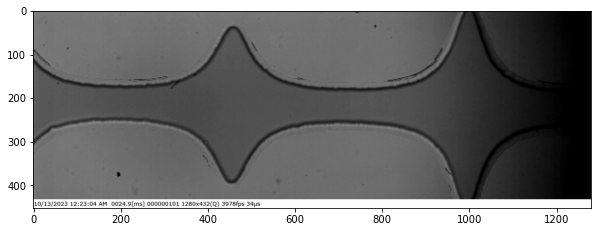

In [10]:
plt.imshow(ref)

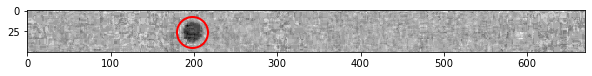

<AxesSubplot:>

In [12]:
crop_ys=190
crop_ye=240

crop_xs=120
crop_xe=790

frame=1253
size=31
target=img_tif[frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100
f_locate = tp.locate(target, size, minmass=2000, invert=True)
tp.annotate(f_locate, target, plot_style={'markersize': size})

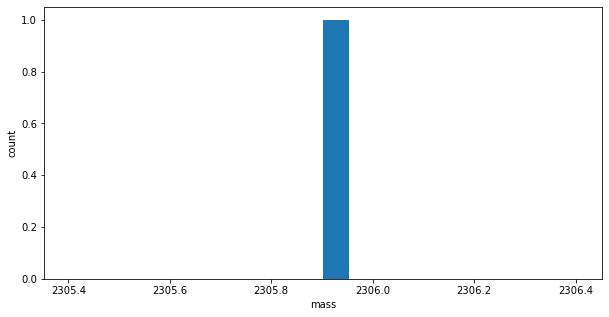

In [13]:
fig, ax = plt.subplots()
ax.hist(f_locate['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [14]:
start_frame=359
end_frame=3800


In [15]:
img_tif.shape

(11855, 452, 1280)

In [12]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    tp.batch(img_tif[start_frame:end_frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100,size, minmass=2000, invert=True, processes=1,output=s)

Frame 3440: 1 features


In [13]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 100, memory=0,link_strategy='hybrid'):
        s.put(linked)

Frame 3440: 1 trajectories present.


In [16]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    t = pd.concat(iter(s))

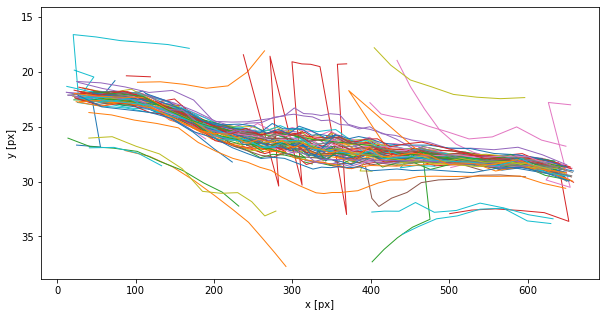

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [17]:
plt.figure()
tp.plot_traj(t)

In [18]:
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 143
After: 35


In [19]:
t1_modified = t1.copy()
t1_modified['y'] = t1['y'] + crop_ys
t1_modified['x'] = t1['x'] + crop_xs
t1_modified['frame'] = t1['frame']+start_frame

In [20]:
t1_modified['particle'].unique()

array([  3,   8,  14,  38,  44,  50,  51,  52,  53,  54,  55,  56,  57,
        61,  62,  63,  64,  65,  66,  69,  70,  72,  83,  90,  91, 100,
       105, 115, 116, 117, 120, 121, 122, 140, 141])

Text(0.5, 0, 's')

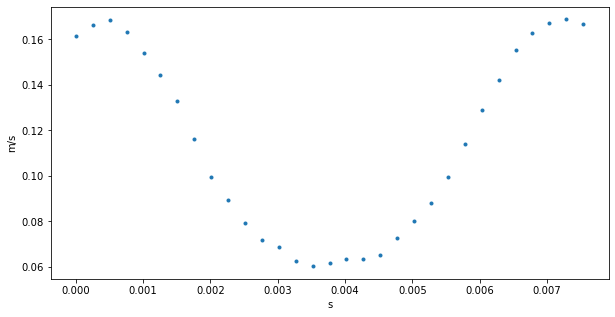

In [22]:
dt=1/framerate #s

scale=10**(-6)/scale_px #um/px

x_pos=t1_modified[(t1_modified['particle'] == 141)]['x']

v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

# Trace Particle Deformations

## velocity and stress field
for one single beads
- sanity check for edge detection and fitting algorithm
- this beads gives the velocity and rescales for the stress field

In [23]:
yloc=219
xloc=393

roi=25
parts=img_tif[1208][yloc-roi:yloc+roi,xloc-roi:xloc+roi]-ref[yloc-roi:yloc+roi,xloc-roi:xloc+roi]+100
blur_parts=cv2.GaussianBlur(parts,(7,7),3)

In [24]:
y_i, x_i=utils.detect_edge_sigmoid(blur_parts,roi)

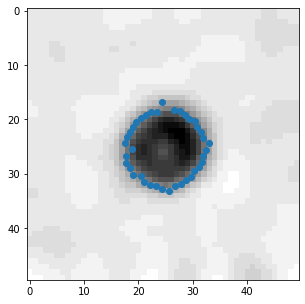

In [25]:
plt.imshow(blur_parts)
plt.plot(x_i,y_i,'o')

In [26]:
dire='/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/test'
gamma_2 = utils.process_frames(img_tif,ref,t1_modified,141,dire)

frame number is3723
frame number is3724
frame number is3725
frame number is3726
frame number is3727
frame number is3728


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3729
frame number is3730


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3731
frame number is3732


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3733
frame number is3734
frame number is3735
frame number is3736
frame number is3737
frame number is3738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3739
frame number is3740
frame number is3741
frame number is3742


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3743
frame number is3744
frame number is3745
frame number is3746
frame number is3747
frame number is3748
frame number is3749
frame number is3750
frame number is3751
frame number is3752
frame number is3753


### velocity

Text(0.5, 0, 's')

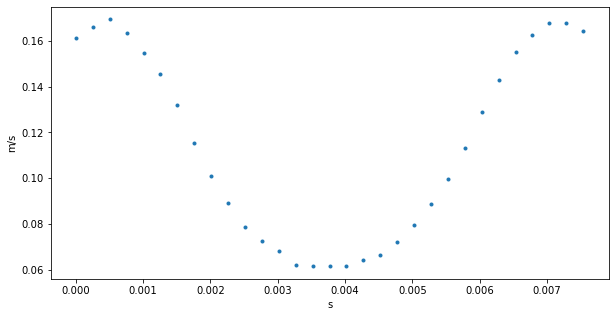

In [27]:
x_pos=t1_modified[(t1_modified['particle'] == 141)]['x']

v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

In [28]:
max_velocity=np.mean(sorted(v, reverse=True)[:2])
print(max_velocity)

0.16875828314093128


### rescale for stress field

In [29]:
real_stress=utils.calculate_stress(max_velocity)
print('The real stess amplitude in this experiment is '+str(real_stress)+' Pa.')

Q is: 5913.290241258232 ul/h
The real stess amplitude in this experiment is 20.55234805394913 Pa.


### fit for G' and G''

In [30]:
type(gamma_2)

list

806.274553289045
Storage modulus is:300.3045843008668
Loss modulus is:97.34568000708774
R^2: 0.8239795795855511
[ 0.06510332  2.82812387 -0.00897951]


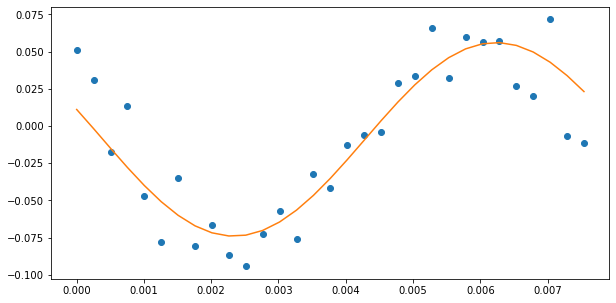

(300.3045843008668, 97.34568000708774, 806.274553289045, 0.8239795795855511)

In [31]:
utils.calculate_modulus(framerate,gamma_2,real_stress)

# process all beads

In [32]:
wavelength1=t1_modified[(t1_modified['x'] >= 187) & (t1_modified['x'] <= 719)]

In [33]:
wavelength1['particle'].unique()

array([  3,   8,  14,  38,  44,  50,  51,  52,  53,  54,  55,  56,  57,
        61,  62,  63,  64,  65,  66,  69,  70,  72,  83,  90,  91, 100,
       105, 115, 116, 117, 120, 121, 122, 140, 141])

In [34]:
gamma2list=utils.analyze_wavelength_gamma2(wavelength1,1,imgname,img_tif, ref)

particle number: 3
frame number is383
frame number is384
frame number is385
frame number is386


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is387
frame number is388


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is389
frame number is390


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is391
frame number is392
frame number is393
frame number is394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is395
frame number is396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is397
frame number is399


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is400
frame number is401


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is404
frame number is405
frame number is407
frame number is408
particle number: 8
frame number is442
frame number is443
frame number is444
frame number is445
frame number is446
frame number is447
frame number is448
frame number is449
frame number is450
frame number is451
frame number is452
frame number is453
frame number is454
frame number is455
frame number is456
frame number is457
frame number is458
frame number is459
frame number is460
frame number is462


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is463
frame number is465
frame number is466
frame number is467
frame number is468
particle number: 14
frame number is632
frame number is633
frame number is634


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is635
frame number is636
frame number is637
frame number is638
frame number is639
frame number is640
frame number is641
frame number is642
frame number is643
frame number is644
frame number is645
frame number is646
frame number is647
frame number is648
frame number is649
frame number is650
frame number is651
frame number is652
frame number is653
frame number is654
frame number is655
frame number is656
frame number is657
particle number: 38
frame number is887
frame number is888
frame number is889
frame number is890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is891
frame number is892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is893
frame number is894
frame number is895
frame number is896


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is897
frame number is898
frame number is899
frame number is900


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is901
frame number is902
frame number is903
frame number is904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is905
frame number is907


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is908
frame number is909
frame number is910
frame number is911
frame number is912
particle number: 44
frame number is1022
frame number is1023
frame number is1024
frame number is1025
frame number is1026
frame number is1027
frame number is1028
frame number is1029
frame number is1030
frame number is1031
frame number is1032


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1033
frame number is1034


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1035
frame number is1036


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1037
frame number is1038
frame number is1039
frame number is1040
frame number is1041
frame number is1042
frame number is1043
frame number is1044
frame number is1045
frame number is1046
frame number is1047
frame number is1048
particle number: 50
frame number is1060
frame number is1061
frame number is1062
frame number is1063
frame number is1064
frame number is1065
frame number is1066
frame number is1067
frame number is1068
frame number is1069


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1070
frame number is1071
frame number is1072
frame number is1073


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1074
frame number is1075
frame number is1078
frame number is1079
frame number is1080
frame number is1081
frame number is1082
frame number is1083
frame number is1084
frame number is1085
frame number is1086
particle number: 51
frame number is1199
frame number is1200
frame number is1201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1202
frame number is1203
frame number is1204
frame number is1205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1206
frame number is1207


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1208
frame number is1209
frame number is1210
frame number is1211


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1212
frame number is1213


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1214
frame number is1215
frame number is1216
frame number is1217
frame number is1218
frame number is1219
frame number is1220


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1221
frame number is1222
frame number is1223
frame number is1224
frame number is1225
frame number is1226


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1227
frame number is1228
particle number: 52
frame number is1249
frame number is1250


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1251
frame number is1252
frame number is1253
frame number is1255


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1256
frame number is1257
frame number is1258
frame number is1263
frame number is1264
frame number is1265


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1266
frame number is1267
frame number is1268
frame number is1269
frame number is1270
frame number is1271
frame number is1272
frame number is1273
frame number is1274
frame number is1275
particle number: 53
frame number is1487
frame number is1488


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1489
frame number is1490
frame number is1491
frame number is1492


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1493
frame number is1494
frame number is1495
frame number is1496
frame number is1497
frame number is1498
frame number is1499
frame number is1500
frame number is1501
frame number is1502
frame number is1503
frame number is1504
frame number is1505
frame number is1506
frame number is1507


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1508
frame number is1509


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1510
frame number is1511
frame number is1512
frame number is1513


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 54
frame number is1500
frame number is1501
frame number is1502
frame number is1503
frame number is1504
frame number is1505


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1506
frame number is1507
frame number is1508
frame number is1509
frame number is1510
frame number is1511
frame number is1512
frame number is1513
frame number is1514
frame number is1515
frame number is1516
frame number is1517
frame number is1518
frame number is1519
frame number is1520
frame number is1521
frame number is1522
frame number is1523
frame number is1524
frame number is1525
frame number is1526
particle number: 55
frame number is1543
frame number is1544
frame number is1545
frame number is1546
frame number is1547
frame number is1548
frame number is1549
frame number is1550
frame number is1551
frame number is1552
frame number is1553
frame number is1554
frame number is1557
frame number is1558
frame number is1559
frame number is1561
frame number is1563
frame number is1564
frame number is1566
frame number is1567
frame number is1568
frame number is1569
particle number: 56
frame number is1584
frame number is1585
frame number is1586


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1587
frame number is1588
frame number is1589
frame number is1590


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1591
frame number is1592
frame number is1593
frame number is1594
frame number is1595
frame number is1596
frame number is1597
frame number is1598
frame number is1599
frame number is1600
frame number is1601


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1602
frame number is1603
frame number is1604
frame number is1605
frame number is1606
frame number is1607
frame number is1608
frame number is1609
frame number is1610
particle number: 57
frame number is1594
frame number is1595
frame number is1596
frame number is1597
frame number is1598
frame number is1599
frame number is1600
frame number is1601
frame number is1602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1603
frame number is1604
frame number is1605
frame number is1606
frame number is1607
frame number is1608


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1609
frame number is1610
frame number is1611
frame number is1612
frame number is1613
frame number is1614
frame number is1615
frame number is1616
frame number is1617
frame number is1618
frame number is1619
frame number is1620
particle number: 61
frame number is1696
frame number is1697
frame number is1698
frame number is1699
frame number is1700
frame number is1701
frame number is1702
frame number is1703
frame number is1704
frame number is1705
frame number is1706
frame number is1707
frame number is1708
frame number is1710
frame number is1712
frame number is1713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1714
frame number is1718


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1719
frame number is1720
frame number is1721
particle number: 62
frame number is1756
frame number is1757
frame number is1758
frame number is1759
frame number is1760
frame number is1761
frame number is1762
frame number is1763
frame number is1764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1765
frame number is1766
frame number is1767
frame number is1768


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1769
frame number is1772
frame number is1773
frame number is1774


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1775
frame number is1776
frame number is1777
frame number is1778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1779
frame number is1781
frame number is1782
particle number: 63
frame number is1793
frame number is1794
frame number is1795
frame number is1796
frame number is1797
frame number is1798
frame number is1799
frame number is1800
frame number is1801
frame number is1802
frame number is1803
frame number is1804
frame number is1805
frame number is1806
frame number is1807


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1808
frame number is1809
frame number is1810
frame number is1811
frame number is1812
frame number is1813
frame number is1814
frame number is1815
frame number is1816
frame number is1817
frame number is1818
frame number is1819
particle number: 64
frame number is1831
frame number is1832
frame number is1833
frame number is1834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1835
frame number is1836
frame number is1837
frame number is1838
frame number is1839
frame number is1840
frame number is1841
frame number is1842
frame number is1843
frame number is1844
frame number is1845
frame number is1846
frame number is1847
frame number is1848


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1849
frame number is1850
frame number is1851
frame number is1852
frame number is1853
frame number is1854
frame number is1855
frame number is1856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1857
particle number: 65
frame number is1923
frame number is1924
frame number is1925
frame number is1926
frame number is1927
frame number is1928
frame number is1929


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1930
frame number is1931


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1932
frame number is1933
frame number is1934
frame number is1935


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1936
frame number is1937
frame number is1938
frame number is1939
frame number is1940
frame number is1941


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1942
frame number is1944
frame number is1945
frame number is1947
frame number is1948
particle number: 66
frame number is2030
frame number is2031
frame number is2032
frame number is2033
frame number is2034
frame number is2035
frame number is2036
frame number is2037
frame number is2038


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2039
frame number is2040
frame number is2041
frame number is2042
frame number is2043
frame number is2044
frame number is2045
frame number is2046


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2047
frame number is2048


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2049
frame number is2050


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2051
frame number is2052
frame number is2053
frame number is2054


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2055
frame number is2056
particle number: 69
frame number is2064
frame number is2065
frame number is2066
frame number is2067


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2068
frame number is2069
frame number is2070
frame number is2071
frame number is2072
frame number is2073
frame number is2074
frame number is2075
frame number is2077
frame number is2078


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2079
frame number is2080
frame number is2081
frame number is2082


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2083
frame number is2084
frame number is2085
frame number is2086
frame number is2087
frame number is2088
frame number is2089
frame number is2090
particle number: 70
frame number is2087
frame number is2088
frame number is2089
frame number is2090
frame number is2091
frame number is2092
frame number is2093
frame number is2094
frame number is2095
frame number is2096
frame number is2097
frame number is2098
frame number is2099
frame number is2100
frame number is2101
frame number is2102


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2103
frame number is2104
frame number is2105
frame number is2107
frame number is2109
frame number is2110
frame number is2111
frame number is2112


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2113
particle number: 72
frame number is2164


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2165
frame number is2166
frame number is2167
frame number is2168
frame number is2169
frame number is2170


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2171
frame number is2172
frame number is2173
frame number is2174
frame number is2175
frame number is2176
frame number is2177
frame number is2178


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2179
frame number is2180
frame number is2182
frame number is2184
frame number is2185
frame number is2186


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2187
frame number is2188
frame number is2189
particle number: 83
frame number is2365
frame number is2366
frame number is2367
frame number is2368
frame number is2369
frame number is2370
frame number is2371
frame number is2372
frame number is2373
frame number is2374
frame number is2375


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2376
frame number is2377
frame number is2378
frame number is2379
frame number is2380
frame number is2381
frame number is2382
frame number is2383
frame number is2384
frame number is2385
frame number is2386
frame number is2387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2388
frame number is2389
frame number is2390
frame number is2391
particle number: 90
frame number is2582
frame number is2583
frame number is2584
frame number is2585
frame number is2586
frame number is2587
frame number is2588
frame number is2589
frame number is2590


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2591
frame number is2592
frame number is2593
frame number is2594
frame number is2595
frame number is2597
frame number is2598
frame number is2601


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2602
frame number is2603


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2604
frame number is2605
frame number is2606
frame number is2607
frame number is2608
particle number: 91
frame number is2709
frame number is2710
frame number is2711
frame number is2712


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2713
frame number is2714
frame number is2715
frame number is2716
frame number is2717
frame number is2718


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2720
frame number is2721
frame number is2722
frame number is2724


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2725
frame number is2727


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2728
frame number is2729
frame number is2730
frame number is2731
frame number is2732
frame number is2733
frame number is2734
frame number is2735
particle number: 100
frame number is2742
frame number is2743
frame number is2744
frame number is2745


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2746
frame number is2747


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2748
frame number is2749
frame number is2750
frame number is2751


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2752
frame number is2753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2754
frame number is2755


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2756
frame number is2757


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2758
frame number is2759
frame number is2760
frame number is2761
frame number is2762
frame number is2763


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2764
frame number is2765
frame number is2766
frame number is2767
particle number: 105
frame number is2777
frame number is2778
frame number is2779
frame number is2780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2781
frame number is2782
frame number is2783
frame number is2784
frame number is2785
frame number is2786
frame number is2787
frame number is2788
frame number is2789
frame number is2792
frame number is2793
frame number is2794
frame number is2795
frame number is2797


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2798
frame number is2799
frame number is2800
frame number is2801
frame number is2802
frame number is2803
particle number: 115
frame number is2900
frame number is2901
frame number is2902
frame number is2903
frame number is2904
frame number is2905


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2906
frame number is2907
frame number is2908
frame number is2909
frame number is2910
frame number is2911


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2912
frame number is2913
frame number is2914
frame number is2915
frame number is2916
frame number is2917
frame number is2918
frame number is2919


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2920
frame number is2921
frame number is2922
frame number is2923
frame number is2924
frame number is2925
frame number is2926
particle number: 116
frame number is2940


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2941
frame number is2942
frame number is2944
frame number is2945
frame number is2946
frame number is2947
frame number is2948
frame number is2949


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2950
frame number is2951
frame number is2952
frame number is2953
frame number is2954
frame number is2955
frame number is2956
frame number is2957
frame number is2958
frame number is2959


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2960
frame number is2961
frame number is2964
frame number is2965
frame number is2966
particle number: 117
frame number is2974


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2975
frame number is2976
frame number is2977
frame number is2978


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2979
frame number is2980
frame number is2981
frame number is2982
frame number is2983
frame number is2984


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2985
frame number is2986
frame number is2987
frame number is2989
frame number is2990
frame number is2991


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2992
frame number is2993


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2994
frame number is2995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2996
frame number is2997
frame number is2998
frame number is2999
particle number: 120
frame number is3130
frame number is3131
frame number is3132
frame number is3133
frame number is3134
frame number is3135
frame number is3136
frame number is3137
frame number is3138
frame number is3139


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3140
frame number is3141
frame number is3142
frame number is3143
frame number is3145
frame number is3146


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3147
frame number is3148


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3149
frame number is3150


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3151
frame number is3152


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3153
frame number is3154
frame number is3155
frame number is3156
particle number: 121
frame number is3183
frame number is3184


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3185
frame number is3186
frame number is3187
frame number is3188
frame number is3189
frame number is3190
frame number is3191
frame number is3192
frame number is3193
frame number is3197


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3198
frame number is3199


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3200
frame number is3201
frame number is3202
frame number is3203


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3206
frame number is3207
frame number is3208
frame number is3209
particle number: 122
frame number is3281
frame number is3283
frame number is3284
frame number is3285
frame number is3286
frame number is3287
frame number is3288
frame number is3289


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3290
frame number is3291
frame number is3292
frame number is3294
frame number is3295
frame number is3296


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3297
frame number is3298


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3299
frame number is3300
frame number is3302
frame number is3303
frame number is3304
frame number is3305


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3306
frame number is3307
particle number: 140
frame number is3670
frame number is3671


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3672
frame number is3673
frame number is3674
frame number is3675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3676
frame number is3677
frame number is3678
frame number is3681
frame number is3682
frame number is3683
frame number is3684
frame number is3685


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3686
frame number is3687


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3689
frame number is3690


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3691
frame number is3692
frame number is3693
frame number is3694
frame number is3695
particle number: 141
frame number is3725
frame number is3726
frame number is3727


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3728
frame number is3729


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3730
frame number is3731
frame number is3732
frame number is3733


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3734
frame number is3735
frame number is3736
frame number is3737
frame number is3738
frame number is3739


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3740
frame number is3741
frame number is3742
frame number is3743


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3744
frame number is3745
frame number is3746
frame number is3747
frame number is3748
frame number is3749
frame number is3750
frame number is3751


In [35]:
with open(imgname+'gamma2.pkl', 'wb') as f:
    pickle.dump(gamma2list, f)

particle is:3
1136.114143270927
Storage modulus is:241.46816647040743
Loss modulus is:187.7143132442954
R^2: 0.8773606560750776
[ 0.06719772  2.48079276 -0.03214543]


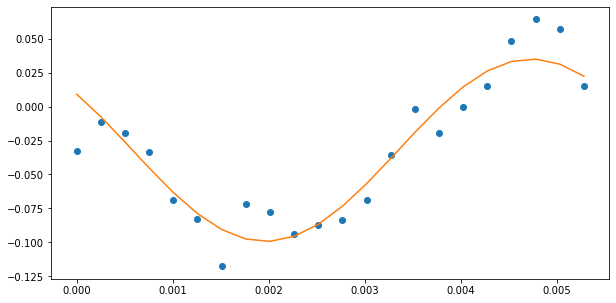

particle is:8
999.7804460784157
Storage modulus is:286.44360156719387
Loss modulus is:94.87346507388106
R^2: 0.9265505248125815
[ 0.06811132  2.82175281 -0.00455146]


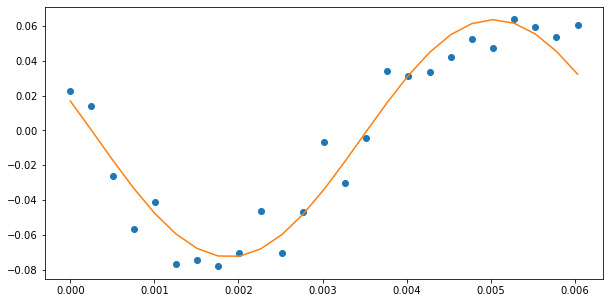

particle is:14
961.3273519984766
Storage modulus is:323.93568646175663
Loss modulus is:35.76525722742428
R^2: 0.8788408486850929
[ 6.30625636e-02  3.03162952e+00 -6.32578034e-04]


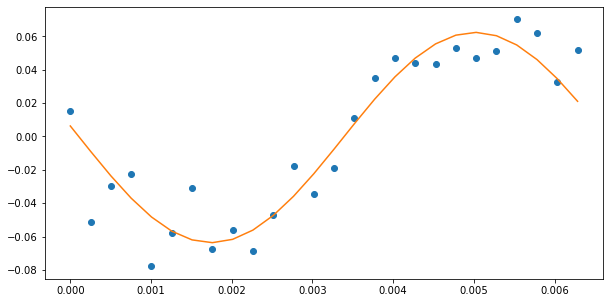

particle is:38
999.7804460784157
Storage modulus is:297.1379114871591
Loss modulus is:136.52154314600403
R^2: 0.8439122882943604
[ 0.0628512   2.7109037  -0.00957554]


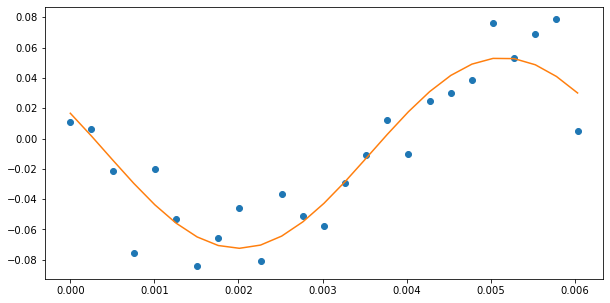

particle is:44
925.7226352577924
Storage modulus is:349.8057872059856
Loss modulus is:112.91018670420303
R^2: 0.9239296929766592
[0.05591305 2.8293703  0.02906973]


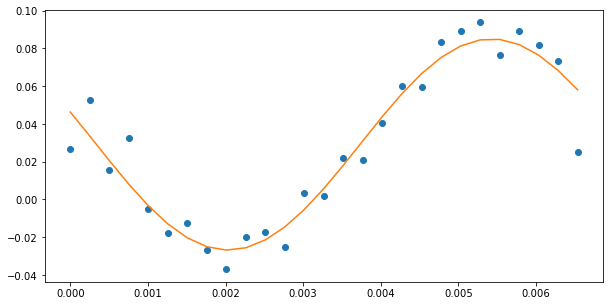

particle is:50
999.7804460784157
Storage modulus is:356.7370746783103
Loss modulus is:136.91554988807562
R^2: 0.8854644630682771
[0.05378663 2.77512966 0.02413863]


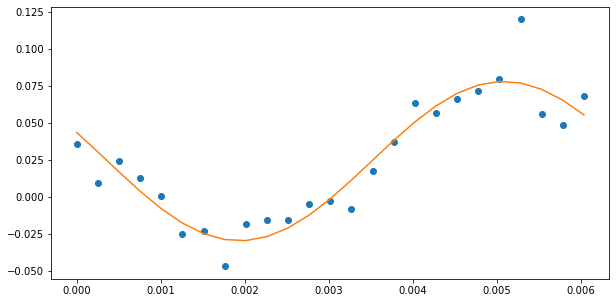

particle is:51
833.1503717320131
Storage modulus is:585.6379688777788
Loss modulus is:1283.8036573351524
R^2: 0.25433546125376005
[0.01456506 1.99877275 0.01602697]


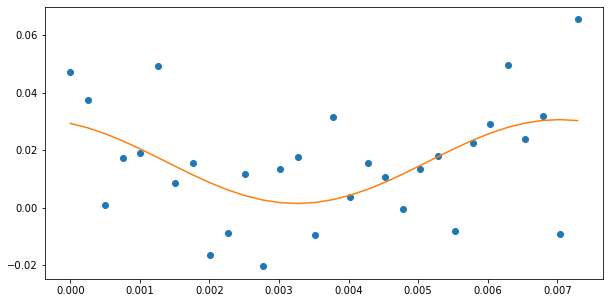

particle is:52
1136.114143270927
Storage modulus is:441.55039920443755
Loss modulus is:1.960877678916784e-13
R^2: 0.7362888458208655
[4.65458713e-02 3.14159265e+00 1.20071961e-03]


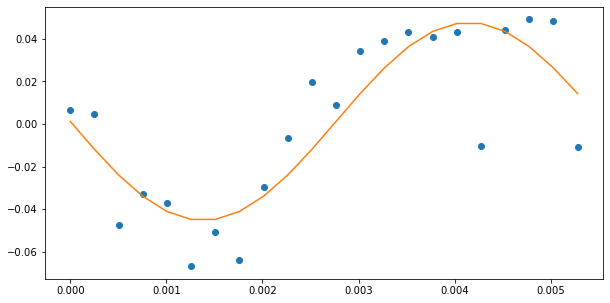

particle is:53
925.7226352577924
Storage modulus is:256.6873826920843
Loss modulus is:82.83165062141335
R^2: 0.9323841007139841
[7.61985058e-02 2.82944726e+00 2.39943894e-03]


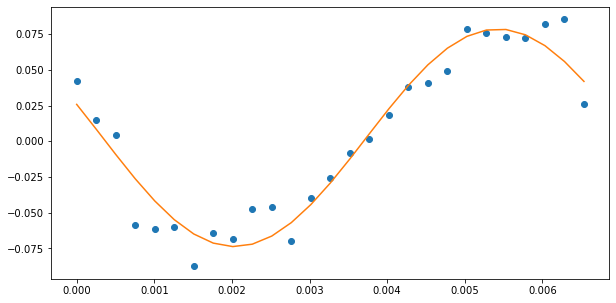

particle is:54
925.7226352577924
Storage modulus is:285.3094353248302
Loss modulus is:102.56609850980128
R^2: 0.8898992511910291
[0.06778809 2.79648798 0.06991687]


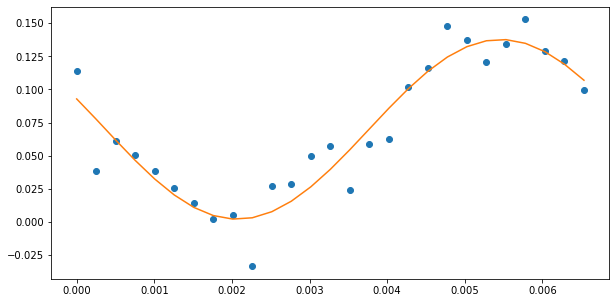

particle is:55
1136.114143270927
Storage modulus is:311.80678331561853
Loss modulus is:128.66139177288557
R^2: 0.847367859771248
[6.09303650e-02 2.75024445e+00 1.21902540e-03]


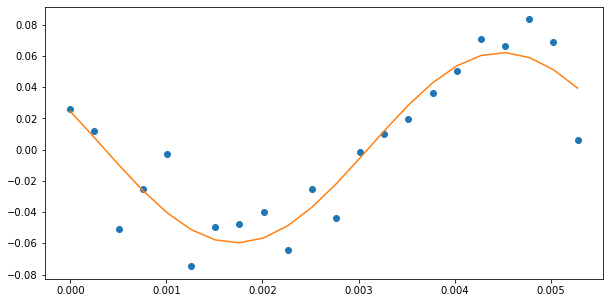

particle is:56
925.7226352577924
Storage modulus is:398.4765078372332
Loss modulus is:64.12443089501085
R^2: 0.9072281974026538
[5.09221747e-02 2.98203659e+00 2.87037436e-03]


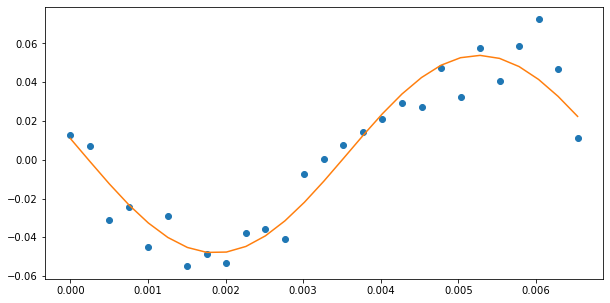

particle is:57
925.7226352577924
Storage modulus is:303.6055038197559
Loss modulus is:97.27895082822589
R^2: 0.8661972778784163
[0.06446592 2.83151571 0.04957097]


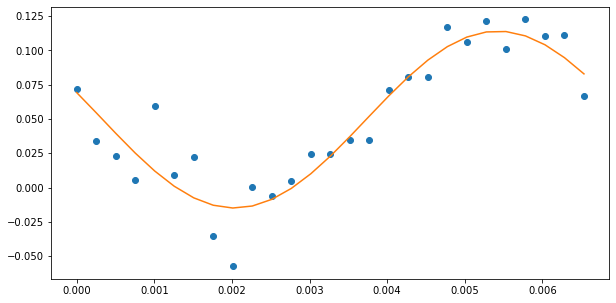

particle is:61
1190.2148167600187
Storage modulus is:291.10860664016417
Loss modulus is:207.44740338746598
R^2: 0.8408961568236085
[ 5.74952948e-02  2.52245250e+00 -1.57502016e-03]


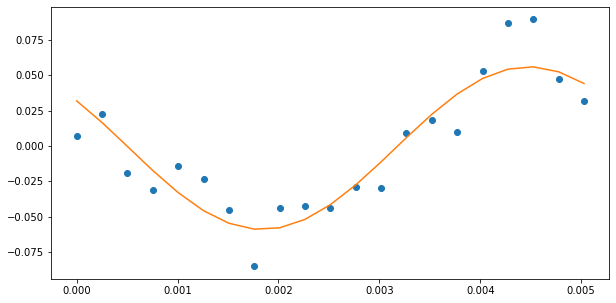

particle is:62
1041.4379646650164
Storage modulus is:232.5907370686437
Loss modulus is:162.35995675675483
R^2: 0.9360227507800318
[ 0.07245587  2.53217663 -0.00255726]


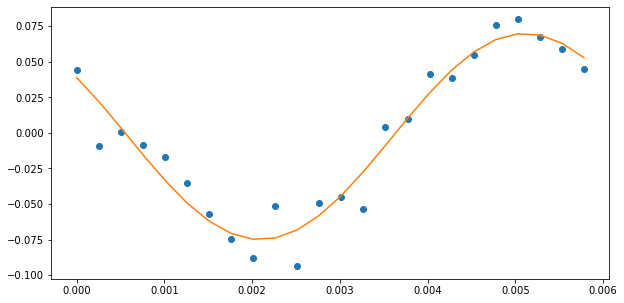

particle is:63
925.7226352577924
Storage modulus is:285.48859528873146
Loss modulus is:107.34411839672254
R^2: 0.8741360565506694
[ 0.06738421  2.78194431 -0.00432381]


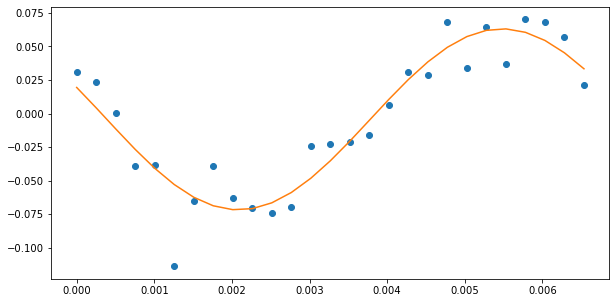

particle is:64
925.7226352577924
Storage modulus is:259.41509960545375
Loss modulus is:96.09475195319617
R^2: 0.901734406460134
[ 0.07429241  2.78683587 -0.01546331]


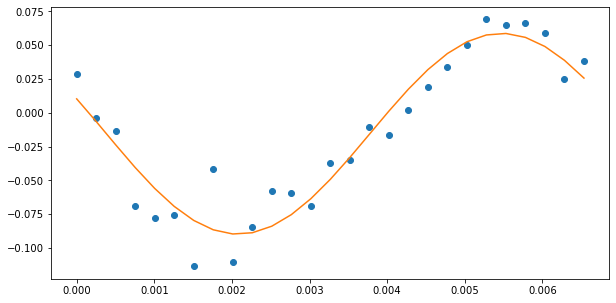

particle is:65
1041.4379646650164
Storage modulus is:370.56408034987317
Loss modulus is:196.2050977982035
R^2: 0.8052465415073181
[ 0.04901562  2.6546426  -0.00297153]


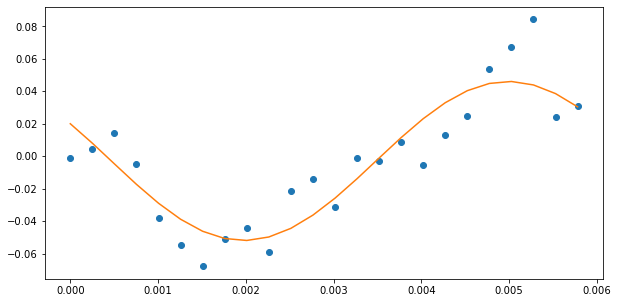

particle is:66
925.7226352577924
Storage modulus is:223.02940935355196
Loss modulus is:142.50412710859433
R^2: 0.9352099848428641
[ 0.0776531   2.57302635 -0.00520664]


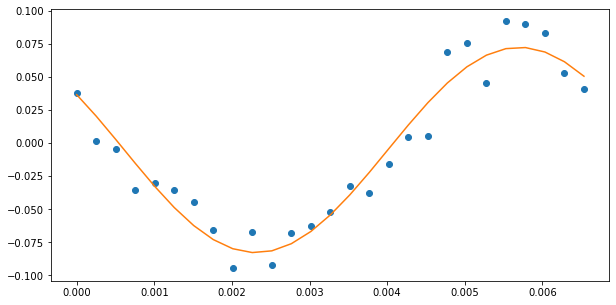

particle is:69
961.3273519984766
Storage modulus is:357.8016252719777
Loss modulus is:152.62307488215237
R^2: 0.735468979265175
[ 5.28347064e-02  2.73840327e+00 -2.49566578e-03]


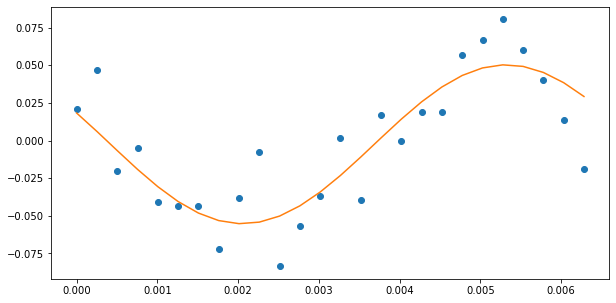

particle is:70
999.7804460784157
Storage modulus is:239.5703592571906
Loss modulus is:130.23147808302048
R^2: 0.8434094557193579
[ 0.07537177  2.64367302 -0.01958112]


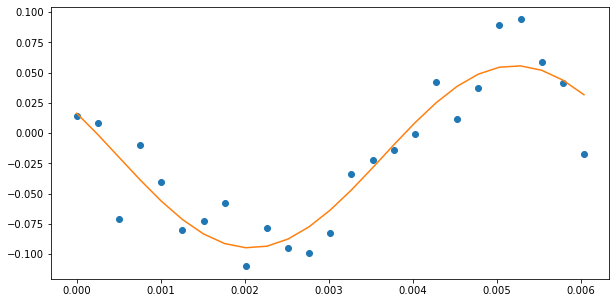

particle is:72
1041.4379646650164
Storage modulus is:405.95968657684887
Loss modulus is:100.2175469219077
R^2: 0.8120780869093126
[ 0.04915102  2.89956603 -0.01182296]


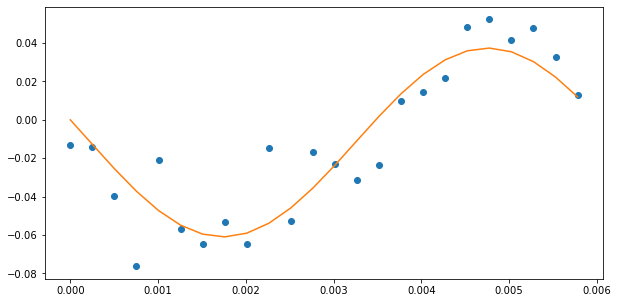

particle is:83
925.7226352577924
Storage modulus is:284.9034355140444
Loss modulus is:15.61427857679899
R^2: 0.9312527060531184
[0.07202985 3.08684192 0.07519734]


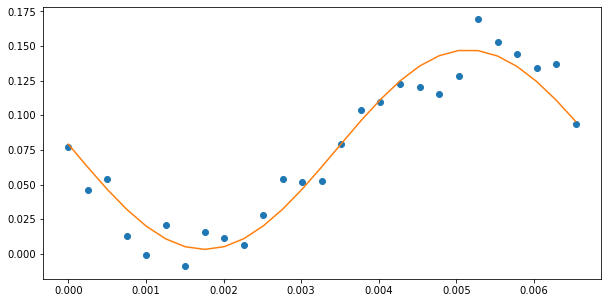

particle is:90
1041.4379646650164
Storage modulus is:303.09750998809864
Loss modulus is:114.16332926088371
R^2: 0.9027090652885289
[ 6.34557342e-02  2.78137142e+00 -2.23830459e-04]


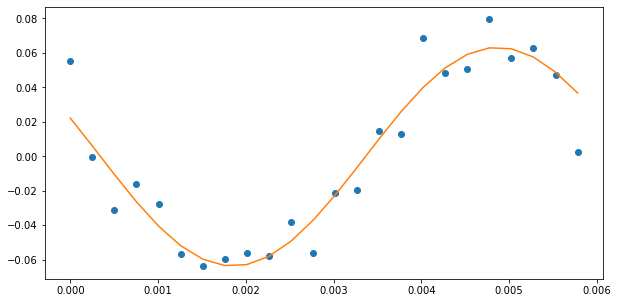

particle is:91
1041.4379646650164
Storage modulus is:313.39347146564273
Loss modulus is:65.72069960304296
R^2: 0.7811906466889837
[0.06418389 2.93488142 0.00719667]


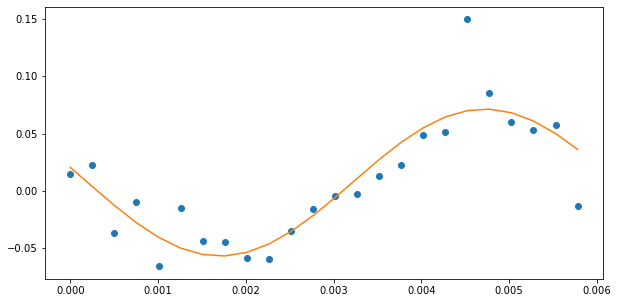

particle is:100
961.3273519984766
Storage modulus is:296.44938717593357
Loss modulus is:83.8329392625897
R^2: 0.8394234576088506
[6.67121596e-02 2.86599861e+00 2.69987472e-04]


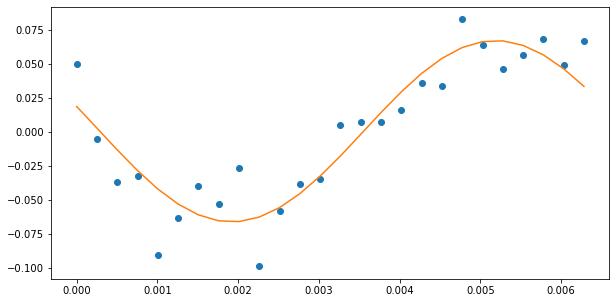

particle is:105
1041.4379646650164
Storage modulus is:240.7449237935525
Loss modulus is:124.79084336556004
R^2: 0.8537338910287935
[ 0.07579256  2.66337071 -0.02491983]


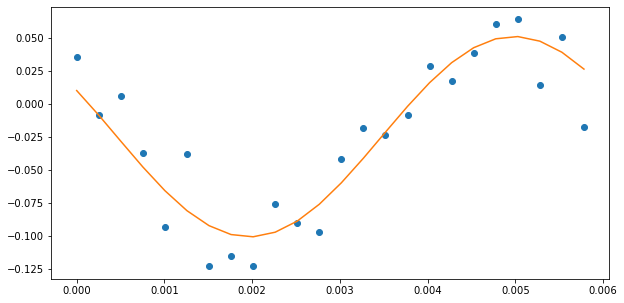

particle is:115
925.7226352577924
Storage modulus is:294.5717582321252
Loss modulus is:55.62029612133605
R^2: 0.7616472048778431
[ 0.06855883  2.95497228 -0.04478139]


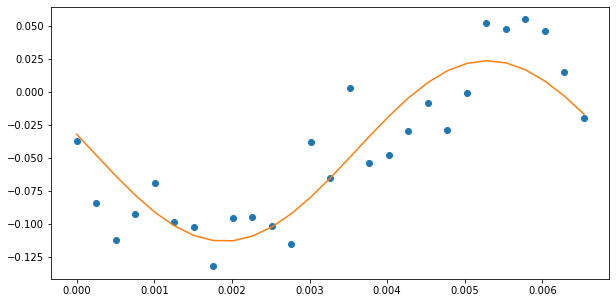

particle is:116
1041.4379646650164
Storage modulus is:154.62496477050655
Loss modulus is:101.42056716412858
R^2: 0.8286065052064014
[ 0.11114248  2.5610717  -0.02493817]


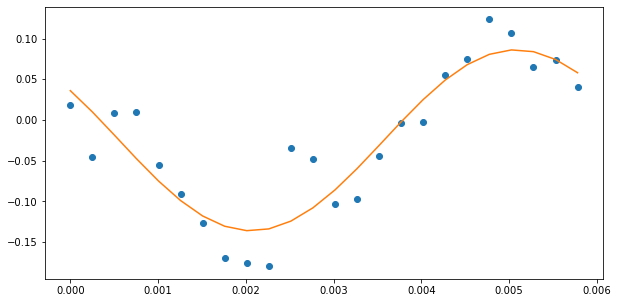

particle is:117
999.7804460784157
Storage modulus is:231.107124177839
Loss modulus is:157.75204012573857
R^2: 0.8815202359928449
[ 0.07344988  2.54264521 -0.01732697]


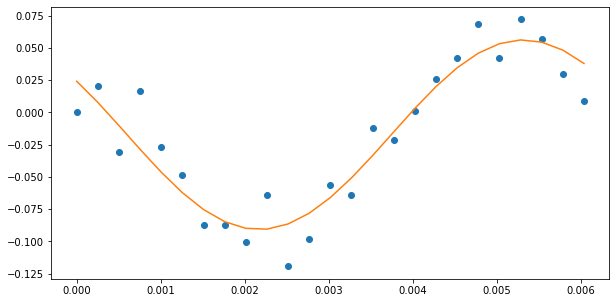

particle is:120
961.3273519984766
Storage modulus is:235.06566738674354
Loss modulus is:89.49510113586791
R^2: 0.9290196187462537
[ 0.08171069  2.7778133  -0.01155332]


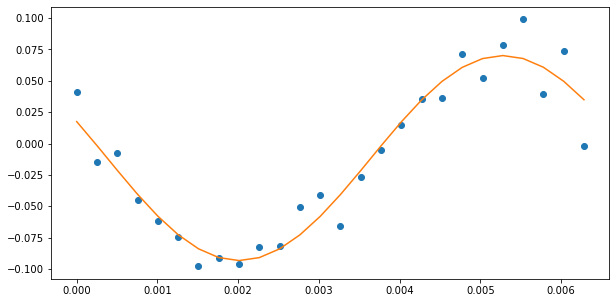

particle is:121
1136.114143270927
Storage modulus is:275.7455114260656
Loss modulus is:110.60428821528545
R^2: 0.89985721990527
[ 0.06917634  2.76012973 -0.01921744]


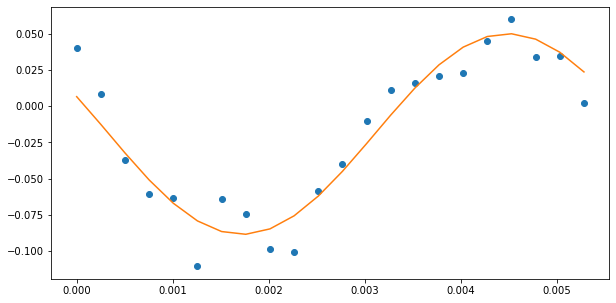

particle is:122
1041.4379646650164
Storage modulus is:254.93132375331612
Loss modulus is:93.2087923587782
R^2: 0.8910169608742105
[ 0.07571692  2.79106802 -0.00556526]


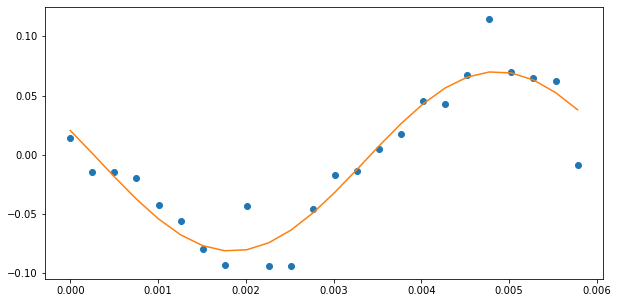

particle is:140
1086.717876172191
Storage modulus is:261.45326309619475
Loss modulus is:34.40357683801558
R^2: 0.8961969676499919
[ 0.07793628  3.01075837 -0.00393064]


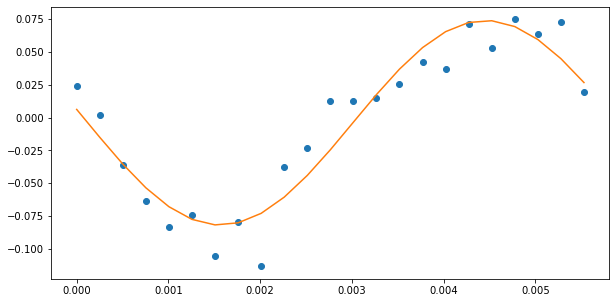

particle is:141
925.7226352577924
Storage modulus is:287.99740560954234
Loss modulus is:67.64323672857921
R^2: 0.8809657684850776
[ 0.06947243  2.91089966 -0.01276608]


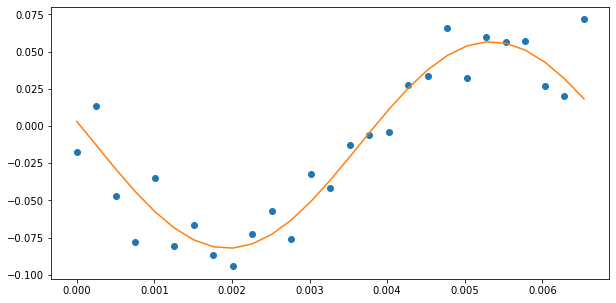

In [36]:
data1=utils.analyze_wavelength_modulus(wavelength1,gamma2list,real_stress,framerate,imgname)

In [37]:
data1

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,3,241.468166,187.714313,1136.114143,0.877361,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
1,8,286.443602,94.873465,999.780446,0.926551,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
2,14,323.935686,35.765257,961.327352,0.878841,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
3,38,297.137911,136.521543,999.780446,0.843912,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
4,44,349.805787,112.910187,925.722635,0.923930,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
5,50,356.737075,136.915550,999.780446,0.885464,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
8,53,256.687383,82.831651,925.722635,0.932384,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
9,54,285.309435,102.566099,925.722635,0.889899,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
10,55,311.806783,128.661392,1136.114143,0.847368,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...
11,56,398.476508,64.124431,925.722635,0.907228,0p5low_alg_12p5mM_3500ul_100um_20231013_122302...


In [39]:
data1.to_csv('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/results/122326_new.csv', index=False)